#### Create School Closure Visualization/ Descriptives

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
%matplotlib inline

#### Read In School Closure Data and Match back onto State-County Geocodes from Raw Data

In [2]:
#Read in state ID and county ID from raw NCES data
ids=pd.read_table("data/ccd/2009-10/sc092a.txt")[["NCESSCH","FIPST","CONUM09","LSTATE09","CONAME09"]]
ids.rename(columns={"CONUM09":"CONUM", "LSTATE09": "STATE", "CONAME09":"COUNTY"}, inplace=True)

school=pd.read_pickle("data/school_closure_clean.pkl")
merged=pd.merge(ids, school, how="right", on="NCESSCH")

print "Number of Records ", merged.shape[0]

Number of Records  90713


/Users/willhuguenin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (4,5,8,17,21,24,26,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Calculate School Closure Rate per County for d3 maps

In [3]:
#Convert county geocode to numeric (for TOPOjson object)
merged["CONUM"]=pd.to_numeric(merged.CONUM, errors="coerce")
merged=merged[merged.CONUM.notnull()]
merged["CONUM"] = merged["CONUM"].astype(np.int32)

#Convert county name to proper case and append to state in County Name, ST format
merged["COUNTY"] = merged["COUNTY"].apply(lambda x: x.title())
merged["COUNTY"] = merged[["COUNTY", "STATE"]].apply(lambda x: ", ".join(x), axis=1)

#Calculate Total Number of Schools & Total Number of Closures by County
bycounty = merged.groupby(by=["CONUM", "COUNTY"], as_index=False)[["intercept", "CLOSED"]].sum()
bycounty.rename(columns={"CONUM":"id", "COUNTY":"county_name", "intercept":"schools", "CLOSED":"closures"}, inplace=True)

#Calculate County Closure Rate
bycounty["close_rate"] = bycounty.closures / bycounty.schools

#Output to a TSV file to d3 map
bycounty.to_csv("graphics/d3-map/closures.tsv", sep="\t", index=False)

In [4]:
##Look at county-level data
bycounty.head(5)

,id,county_name,schools,closures,close_rate
0,1001,"Autauga County, AL",12,0,0.000000
1,1003,"Baldwin County, AL",43,1,0.023256
2,1005,"Barbour County, AL",9,1,0.111111
3,1007,"Bibb County, AL",10,1,0.100000
4,1009,"Blount County, AL",16,0,0.000000


#### Paired Bar Graph of Continuous Characteristics by Open vs. Closed

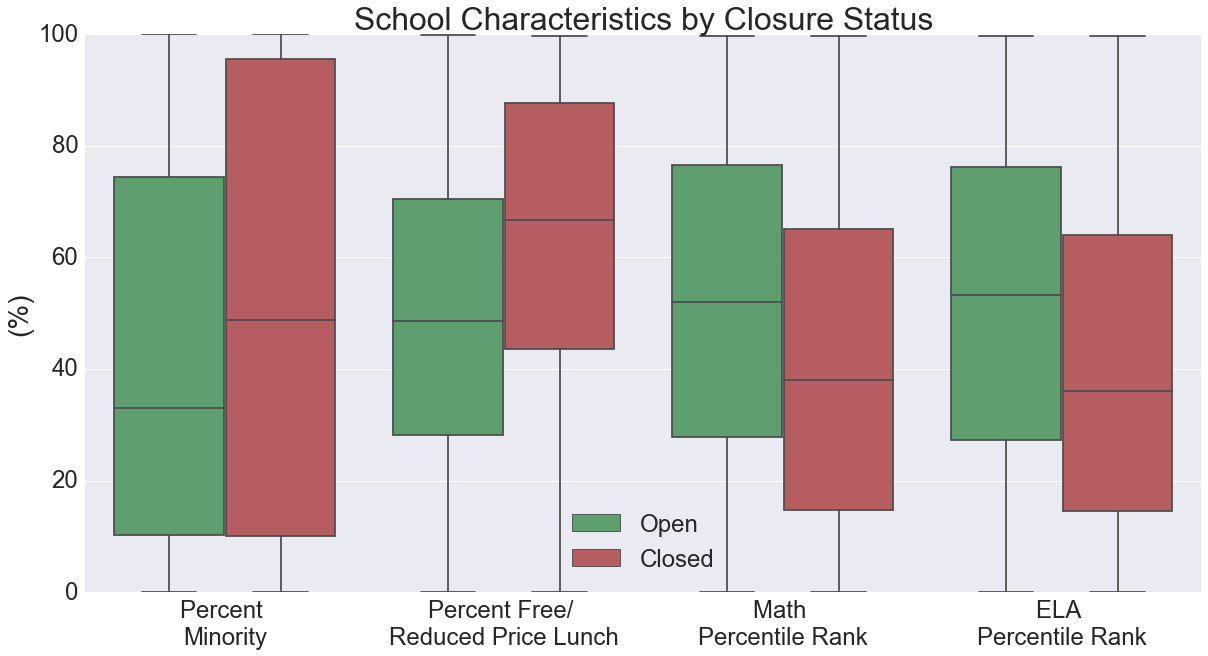

In [8]:
def graph_by_closure(df, variables):
    new_df=pd.DataFrame()
    
    for variable in variables:
        temp_df=pd.DataFrame({"var":variable, "closed": df["CLOSED"], "value": df[variable].apply(lambda x: x*100)})
        
        new_df=pd.concat([new_df, temp_df], axis=0)

    new_df["closed_txt"]="Open"
    new_df.ix[new_df.closed==1, "closed_txt"]="Closed"
      
    return sns.boxplot(x="var", y="value", hue="closed_txt", data=new_df, palette=[green, red])


plt.figure(figsize=(20,10))
green = sns.color_palette("deep")[1]
red = sns.color_palette("deep")[2]

fig = graph_by_closure(merged, ["PCT_MINORITY","PCT_FRL","MATH_RANK","ELA_RANK"])
plt.legend(loc="best", fontsize=24)

plt.xlabel(" ")
plt.ylabel("(%)", fontsize=28)
fig.set_xticklabels(["Percent \nMinority","Percent Free/ \nReduced Price Lunch",\
                     "Math \nPercentile Rank","ELA \nPercentile Rank"])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.title("School Characteristics by Closure Status", fontsize=32)
plt.savefig("graphics/school-char-by-closure.png")